<a href="https://colab.research.google.com/github/Sidarth-V/Anxiet-ease/blob/main/unsegmented_language_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import time
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from torchmetrics.functional.classification import multiclass_precision
from torchmetrics.functional.classification import multiclass_recall
from torchmetrics.functional.classification import multiclass_f1_score

In [35]:
# init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

In [36]:
# importing dataset
INPUTDIR = "drive/My Drive/Team 5_E1/unsegmented.csv"

raw = pd.read_csv(f'{INPUTDIR}')
x_train_full = raw['Text']
y_train_full = raw['language']

print('Example:')
print('LANG =', y_train_full[0])
print('TEXT =', x_train_full[0])

Example:
LANG = Thai
TEXT = ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เริ่มตั้งแต่ถนนสนามไชยถึงแม่น้ำเจ้าพระยาที่ถนนตก กรุงเทพมหานคร เป็นถนนรุ่นแรกที่ใช้เทคนิคการสร้างแบบตะวันตก ปัจจุบันผ่านพื้นที่เขตพระนคร เขตป้อมปราบศัตรูพ่าย เขตสัมพันธวงศ์ เขตบางรัก เขตสาทร และเขตบางคอแหลม


In [37]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

The **Dictionary** class is used to map tokens (characters, words, subwords) into consecutive integer indexes.  
The index **0** is reserved for padding sequences up to a fixed length, and the index **1** for any 'unknown' character

In [38]:
char_vocab = Dictionary()

# reserve index 0 for padding
pad_token = '<pad>'

# reserve index 1 for unknown token
unk_token = '<unk>'

pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
chars = set(''.join(x_train_full))

# obtain the list of different characters with set
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

# creating dictionary with unique languages
lang_vocab = Dictionary()

languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 6962 UTF characters
Labels: 9 languages


In [39]:
# first index of y_train and first 10 characters of x_train
print(y_train_full[0], x_train_full[0][:10])

# converting x_train to indexes of char_vocab
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]

# converting y_train to indexes of lang_vocab
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])

# first index of y_train_to_idx and first 10 idx's of x_train_to_idx
print(y_train_idx[0], x_train_idx[0][:10])

Thai ถนนเจริญกร
8 [512 515 515 548 498 525 541 503 493 525]


Radomly select 20% of the database for validation  
Create lists of (input, target) tuples for training and validation

In [40]:
# splitting into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.2, random_state=42)

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")

7200 training samples
1800 validation samples


In [41]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""

    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [42]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """
    Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

**DNN Model**  
Includes Python comments with the dimension of the input  matrix:

T = Max number of tokens in a sequence (n) <br>
B = Number of sequences (batch size = 256) <br>
E = Embedding dim (64) <br>
H = Hidden size (256) <br>
O = Output size (number of languages = 4) <br>

In [43]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="gru", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):        
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output, _ = padded.max(dim=0)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

In [44]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [45]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

The **nn.CrossEntropyLoss()** criterion combines **nn.LogSoftmax()** and **nn.NLLLoss()** in one single class.  
It is useful when training a classification problem.

In [46]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # extracting x values from generated batch
        X = [ torch.from_numpy(d[0]) for d in batch ]
 
        # length of each x stored in X_lengths and converted to tensor
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)

        # extracting y from each batch into a tensor
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)

        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)

        '''
        model.zero_grad() clears x.grad for every parameter x in the optimizer. 
        It’s important to call this before loss.backward(), otherwise you’ll 
        accumulate the gradients from multiple passes.
        '''
        model.zero_grad()

        output = model(X, X_lengths)

        '''
        loss.backward() computes dloss/dx for every parameter x which has requires_grad=True
        These are accumulated into x.grad for every parameter x
        '''

        loss = criterion(output, y)
        loss.backward()

        ''' 
        A "bad minibatch" can cause gradients to explode for some reason and the entire model 
        can become unstable after the update. A common solution to the exploding gradients 
        problem is limiting the max norm of the gradients with 'gradient clipping'.
        '''
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        # optimizer.step updates the value of x using the gradient x.grad
        optimizer.step()

        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [47]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    nprecision = 0
    nrecall = 0
    nf1score = 0
    count = 0

    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)

            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()

            pred = torch.max(answer, 1)[1]
            

            nprecision += multiclass_precision(pred, y, num_classes=9).item()
            nrecall += multiclass_recall(pred, y, num_classes=9).item()
            nf1score += multiclass_f1_score(pred, y, num_classes=9).item()
            count += 1;
        # calculating metrics
        dev_acc = 100 * ncorrect / nsentences
        precision = round(100 * nprecision / count, 2)
        recall = round(100 * nrecall / count, 3)
        f1score = round(100 * nf1score / count, 2)

    return dev_acc, precision, recall, f1score

In [48]:
hidden_size = 256
embedding_size = 64
bidirectional = False
ntokens = len(char_vocab)
nlabels = len(lang_vocab)

Model for cross-validation

In [49]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [50]:
batch_size, token_size = 256, 200000
epochs = 25
model, optimizer = get_model()
train_accuracy = []
valid_accuracy = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

print(f'Training cross-validation model for {epochs} epochs\n\n')
print("{:<7} | {:<18} | {:<19} | {:<10} | {:<10} | {:<10} | {:<10}".format('Epoch','Training Accuracy','Validation Accuracy', 'Precision', 'Recall', 'F1 Score', 'Learning Rate'))
print('----------------------------------------------------------------------------------------------------------')

for epoch in range(1, epochs + 1):
    train_acc = train(model, optimizer, train_data, batch_size, token_size, log=False)
    valid_acc, precision, recall, f1score = validate(model, val_data, batch_size, token_size)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    scheduler.step()
    # print(f'LR {scheduler.get_last_lr()}')

    print("{:<7} | {:<18} | {:<19} | {:<10} | {:<10} | {:<10} | {:<10}".format(f'{epoch}', f'{train_acc}%', f'{valid_acc}%', f'{precision}%', f'{recall}%', f'{f1score}%', f'{scheduler.get_last_lr()}'))

Training cross-validation model for 25 epochs


Epoch   | Training Accuracy  | Validation Accuracy | Precision  | Recall     | F1 Score   | Learning Rate
----------------------------------------------------------------------------------------------------------
1       | 82.06944444444444% | 95.61111111111111%  | 95.3%      | 94.655%    | 94.55%     | [0.001]   
2       | 96.69444444444444% | 97.33333333333333%  | 96.07%     | 96.032%    | 95.83%     | [0.001]   
3       | 98.06944444444444% | 98.83333333333333%  | 97.44%     | 97.247%    | 97.27%     | [0.001]   
4       | 98.58333333333333% | 98.5%               | 97.2%      | 97.027%    | 97.03%     | [0.001]   
5       | 98.93055555555556% | 98.88888888888889%  | 97.59%     | 97.263%    | 97.37%     | [0.001]   
6       | 99.22222222222223% | 98.88888888888889%  | 97.09%     | 97.305%    | 97.12%     | [0.001]   
7       | 99.30555555555556% | 99.05555555555556%  | 97.69%     | 97.402%    | 97.48%     | [0.001]   
8       | 99.33333

In [51]:
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

embed.weight         445568 [6962, 64]
rnn.weight_ih_l0     49152 [768, 64]
rnn.weight_hh_l0     196608 [768, 256]
rnn.bias_ih_l0       768 [768]
rnn.bias_hh_l0       768 [768]
h2o.weight           2304 [9, 256]
h2o.bias             9 [9]
TOTAL                695177


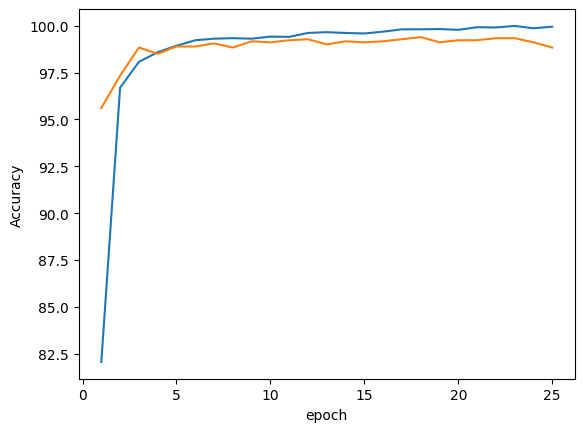

In [52]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

In [53]:
def predict(line):
  data = np.array([char_vocab.token2idx[c] for c in line])
  model.eval()

  with torch.no_grad():
      X = [torch.from_numpy(data)]
      X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)

      X = torch.nn.utils.rnn.pad_sequence(X).to(device)
      answer = model(X, X_lengths)

      index = -1
      m = -1000
      
      for i in range(len(answer[0])):
        if(m < answer[0][i]):
          m = answer[0][i]
          index = i

      for i in lang_vocab.token2idx:
        if lang_vocab.token2idx[i] == index:
          return(i)
      return('Not an unsegmented language')

In [54]:
#From token or label to index
batch_size, token_size = 256, 200000
def verbose_predict(line):
  print('Input string is: ')
  print(line)
  data = np.array([char_vocab.token2idx[c] for c in line])
  print('\nInput after processing into tokens and then converting it to a matrix with indices from char_vocab:')
  print(data)
  # Get input and target sequences from batch
  model.eval()
    # calculate accuracy on validation set
  with torch.no_grad():
      # Get input and target sequences from batch
      X = [torch.from_numpy(data)]
      X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
      # Pad the input sequences to create a matrix
      X = torch.nn.utils.rnn.pad_sequence(X).to(device)
      answer = model(X, X_lengths)
      print('\nTensor corresponding to Chinese, Japanese, Korean, and Thai in order for given input is:')
      print(answer)
      index = -1
      m = -1000
      for i in range(len(answer[0])):
        if(m < answer[0][i]):
          m = answer[0][i]
          index = i

      for i in lang_vocab.token2idx:
        if lang_vocab.token2idx[i] == index:
          print('\nFinally, language detected by RNN is: ')
          return(i)
      return('Not an unsegmented language')

In [55]:
chinese = '胡赛尼本人和小说的主人公阿米尔一样'

verbose_predict(chinese)

Input string is: 
胡赛尼本人和小说的主人公阿米尔一样

Input after processing into tokens and then converting it to a matrix with indices from char_vocab:
[4276 4925 2127 2910 1133 1659 2111 4797 3693 1073 1133 1346 5376 3984
 2114 1037 2980]

Tensor corresponding to Chinese, Japanese, Korean, and Thai in order for given input is:
tensor([[-3.4472,  8.8343, -5.6172, -1.9979, -4.3467, -5.7823, -2.2233, -1.8794,
         -1.3794]], device='cuda:0')

Finally, language detected by RNN is: 


'Chinese'

In [56]:
k = '나는움직이는것이좋아'
c = '我喜欢移动它移动它'
t = 'ฉันชอบที่จะย้ายมันย้ายมัน'
j = '私はそれを動かすのが好きです'
kr = 'Мен кыймылдаганды жакшы көрөм'
kh = 'ខ្ញុំចូលចិត្តផ្លាស់ទី'
ja = 'Aku seneng pindhah'
ar = 'انا احب التحرك'
ge = 'მე მიყვარს გადაადგილება'

print(predict(k))
print(predict(c))
print(predict(t))
print(predict(j))
print(predict(kr))
print(predict(kh))
print(predict(ja))
print(predict(ar))
print(predict(ge))

Korean
Chinese
Thai
Japanese
Kirghiz
Khmer
Javanese
Arabic
Georgian
